## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np
import pandas as pd
import os 


In [23]:
# csv_dir = '../../CCUS/data/well_design_exp3/rst_csv'
# batch_items = ['batch1', 'batch2', 'batch3', 'batch4', 'batch5', 'batch6', 'batch7']

# dfco2 = pd.DataFrame()
# dffault = pd.DataFrame()
# dfdP = pd.DataFrame()
# dfdPres = pd.DataFrame()
# for it in batch_items:
#     dfco2_temp = pd.read_csv(os.path.join(csv_dir, f'{it}_co2_plume_size.csv'))
#     dffault_temp = pd.read_csv(os.path.join(csv_dir, f'{it}_dp_fault2027.csv'))
#     dfdP_temp = pd.read_csv(os.path.join(csv_dir, f'{it}_dp_top.csv'))
#     dfdPres_temp = pd.read_csv(os.path.join(csv_dir, f'{it}_dPres.csv'))
#     dfco2 = pd.concat([dfco2, dfco2_temp])
#     dffault = pd.concat([dffault, dffault_temp])
#     dfdP = pd.concat([dfdP, dfdP_temp])
#     dfdPres = pd.concat([dfdPres, dfdPres_temp])

In [3]:
dfco2 = pd.read_csv('../../CCUS/data/well_design_exp3/rst_csv/batch5_co2_plume_size.csv')
dfall = pd.read_csv('../../CCUS/data/well_design_exp3/well_design_opt_exp3_all.csv')

dfco2['CaseID'] = [f'case{int(x)}' for x in dfco2[['caseid']].values.reshape(-1)]

dfdata = pd.merge(dfall[['CaseID', 'depth, ft', 'deviation, deg', 'length, ft', 'direction, deg']], 
                  dfco2[['CaseID']], how='inner', on='CaseID')

In [4]:
dfdata

,CaseID,"depth, ft","deviation, deg","length, ft","direction, deg"
0,case484,4147.967,95.833,4975.509,225.296
1,case485,4161.727,95.922,4634.502,229.660
2,case486,4174.044,96.019,4325.004,234.688
3,case487,4185.008,96.111,4054.165,240.441
4,case488,4194.718,96.177,3830.126,246.944
...,...,...,...,...,...
107,case600,4687.285,81.443,3850.754,67.074
108,case601,4732.640,80.651,4085.399,60.689
109,case602,4779.027,80.025,4367.178,55.079
110,case603,4826.427,79.537,4687.713,50.210


In [5]:

parameters = dfdata.values[:,1:]
responses = np.load('../pyDGSA/data/video_PCs_batch5.npy')

In [6]:
responses.shape

(112, 41)

In [7]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [8]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [9]:
from pyDGSA.dgsa import dgsa

parameter_names=['depth','deviation','length', 'direction']
mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

           sensitivity  confidence
depth         1.198396    0.550624
deviation     0.816070    0.349175
length        1.748620    0.680290
direction     0.676014    0.295559


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [10]:
cluster_names = ['Low cluster', 'Medium cluster', 'High cluster']

cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

           Low cluster  Medium cluster  High cluster
depth         1.956734        1.520854      1.167876
deviation     1.485905        0.878916      0.799448
length        1.977735        1.665495      3.144302
direction     1.210993        0.844955      0.537022


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [11]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

                      sensitivity
depth | deviation        1.972176
depth | direction        1.855305
deviation | depth        1.805439
deviation | direction    1.801011
direction | deviation    1.738447
direction | depth        1.610006
length | direction       0.732304
depth | length           0.619328
direction | length       0.546592
length | deviation       0.545459
deviation | length       0.474832
length | depth           0.448674


Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [13]:
sens = dgsa_interactions(parameters, labels, 
                         cond_parameters=['depth','deviation','length', 'direction'], 
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

                      sensitivity
depth | deviation        1.811394
deviation | depth         1.59135
direction | deviation    1.460353
depth | direction        1.427893
direction | depth        1.366396
deviation | direction    1.318034
length | direction       0.714209
depth | length            0.50769
length | depth           0.503705
direction | length       0.461271
length | deviation       0.454348
deviation | length       0.401684


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [14]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

                      Low cluster Medium cluster High cluster
deviation | depth        1.824203       1.854335     1.735185
length | depth           0.351175       0.505636     0.489988
direction | depth        1.317776       1.783454        1.753
depth | deviation        1.879686       1.775099     2.311021
length | deviation       0.362681       0.731135     0.547865
direction | deviation    1.532395       1.770472     1.988306
depth | length           0.560792       0.684774     0.600511
deviation | length       0.433429       0.634082     0.354692
direction | length       0.575908       0.637001     0.422283
depth | direction        1.048692       2.367357     2.187174
deviation | direction     1.10817       2.447841     1.852179
length | direction        0.71471       0.918803     0.569566


To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [15]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

                      Low cluster                     Medium cluster  \
                            Bin 0     Bin 1     Bin 2          Bin 0   
deviation | depth        2.178488  1.571902       NaN       2.073243   
length | depth           0.365496  0.325405       NaN       0.579146   
direction | depth        1.585899   1.06042       NaN       1.629046   
depth | deviation             NaN  1.592056   2.09372       2.580559   
length | deviation            NaN  0.581397  0.150961       0.660713   
direction | deviation         NaN  1.311314  1.662191       2.435864   
depth | length                NaN  0.413057   0.72372       0.687123   
deviation | length            NaN  0.298374  0.578406        0.72354   
direction | length            NaN  0.411567  0.743476       0.726872   
depth | direction        1.805405  0.908904  0.386246       2.618225   
deviation | direction    2.030118  0.944726  0.346186       2.620913   
length | direction       1.145028  0.351467  0.608832       0.66

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

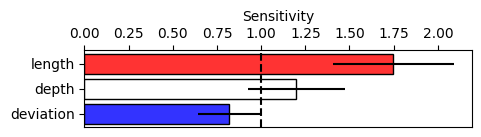

In [16]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

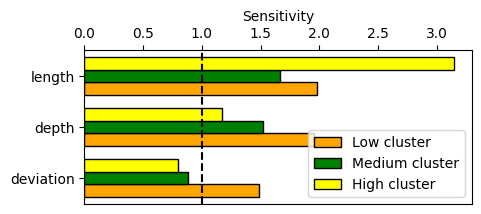

In [17]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'yellow']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=3, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

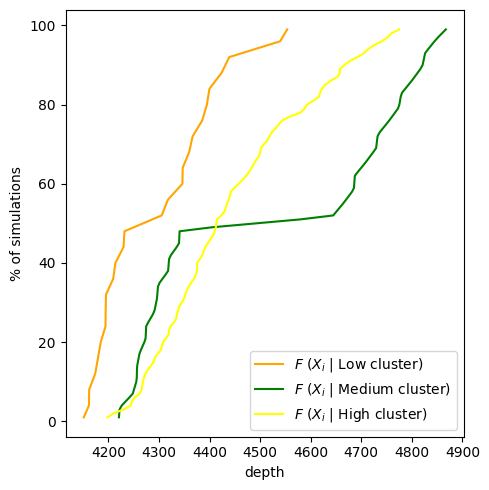

In [18]:
from pyDGSA.plot import plot_cdf

fig, ax = plot_cdf(parameters, labels, 'depth', parameter_names=parameter_names, 
                   cluster_names=cluster_names, colors=cluster_colors)

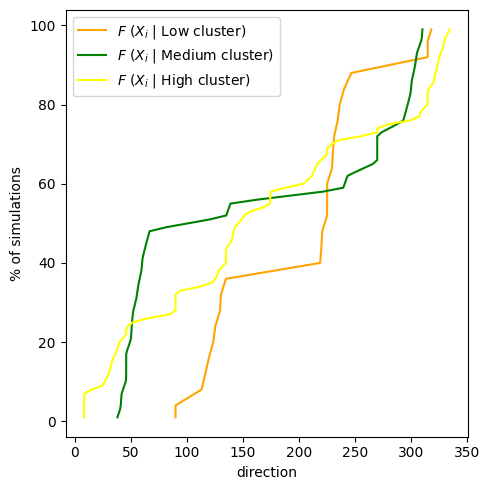

In [19]:
fig, ax = plot_cdf(parameters, labels, 'direction', parameter_names=parameter_names, 
                   cluster_names=cluster_names, colors=cluster_colors)

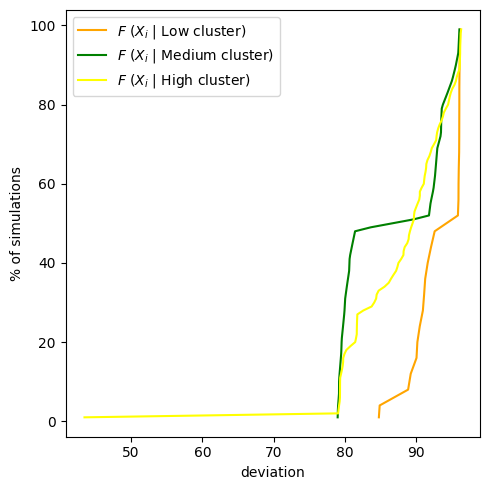

In [20]:
fig, ax = plot_cdf(parameters, labels, 'deviation', parameter_names=parameter_names, 
                   cluster_names=cluster_names, colors=cluster_colors)

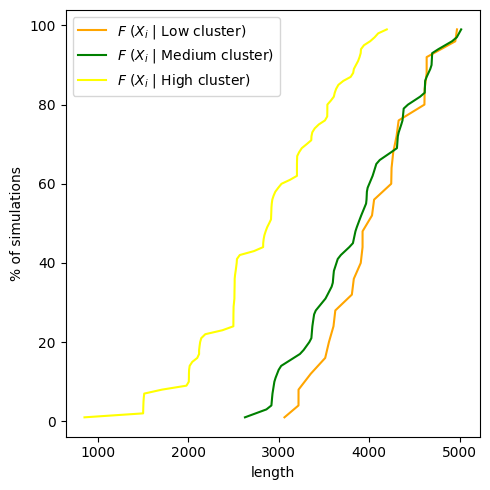

In [21]:
fig, ax = plot_cdf(parameters, labels, 'length', parameter_names=parameter_names, 
                   cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

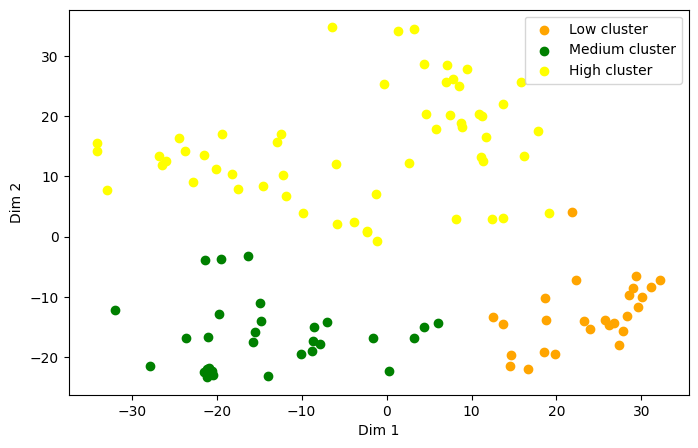

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

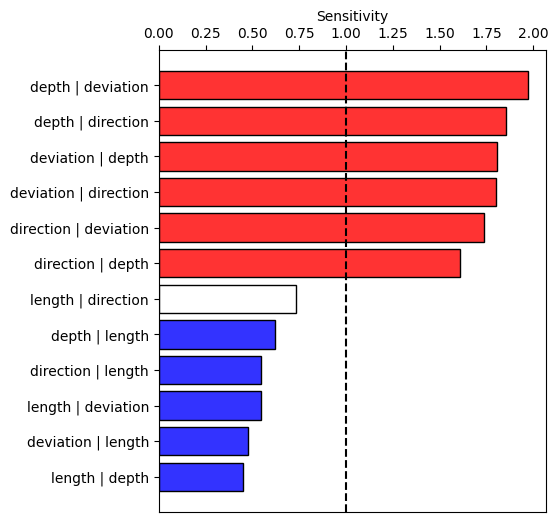

In [23]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

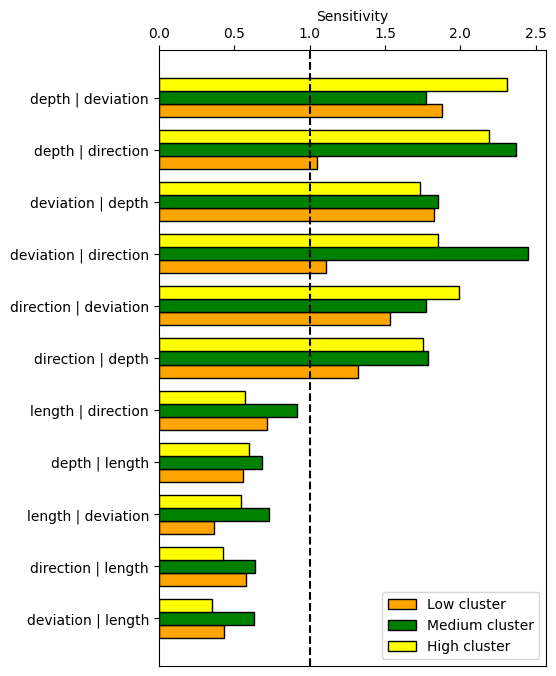

In [24]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

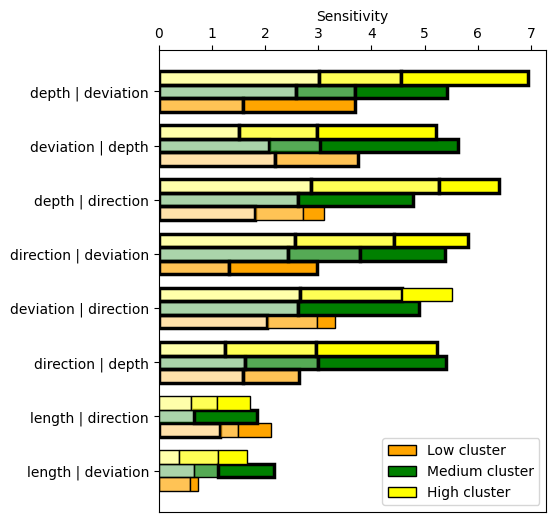

In [25]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)